In [1]:
import sys

!{sys.executable} -m pip install librosa

  Using cached librosa-0.10.2.post1-py3-none-any.whl.metadata (8.6 kB)
  Using cached audioread-3.0.1-py3-none-any.whl.metadata (8.4 kB)
  Using cached soundfile-0.12.1-py2.py3-none-manylinux_2_31_x86_64.whl.metadata (14 kB)
  Using cached pooch-1.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached soxr-0.5.0.post1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached librosa-0.10.2.post1-py3-none-any.whl (260 kB)
Using cached audioread-3.0.1-py3-none-any.whl (23 kB)
Using cached pooch-1.8.2-py3-none-any.whl (64 kB)
Using cached soundfile-0.12.1-py2.py3-none-manylinux_2_31_x86_64.whl (1.2 MB)
Using cached soxr-0.5.0.post1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (252 kB)


In [46]:
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Data Preparation

In [3]:
npz_data = np.load('../../../data/48k_data/training.npz')
meta_data = json.load(open("../../data/48k_data/meta.json", 'r'))

In [4]:
id2label = {v:k for k,v in meta_data['labels'].items()}
id2label

{0: 'Disappointment',
 1: 'Boring',
 2: 'Chanting/Singing',
 3: 'Celebration',
 4: 'Excitement'}

In [5]:
S = librosa.feature.melspectrogram(
    y=npz_data['X'][0],
    sr=meta_data["sample_rate"],
    power=1
)
S = librosa.power_to_db(S, ref=np.max)

In [31]:
S = [librosa.feature.melspectrogram(
        y=x,
        sr=meta_data["sample_rate"],
        power=1) 
     for x in npz_data['X']]

In [32]:
S_db = [librosa.power_to_db(item, ref=np.max) for item in S]

In [33]:
S_db_flattened = [item.flatten() for item in S_db]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(S_db_flattened, npz_data['y'], test_size=0.2, random_state=42)

# Pipeline

In [35]:
model = RandomForestClassifier(random_state=42)

In [36]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('classifier', model) 
])

In [37]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=42))])

# Evaluation

In [42]:
y_pred = pipeline.predict(X_test)

In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.60      0.72        15
           1       0.64      0.67      0.66        57
           2       0.71      0.85      0.78        75
           3       0.57      0.57      0.57        14
           4       0.44      0.19      0.27        21

    accuracy                           0.68       182
   macro avg       0.65      0.58      0.60       182
weighted avg       0.66      0.68      0.66       182



In [53]:
cm = confusion_matrix(y_test, y_pred, normalize='true')

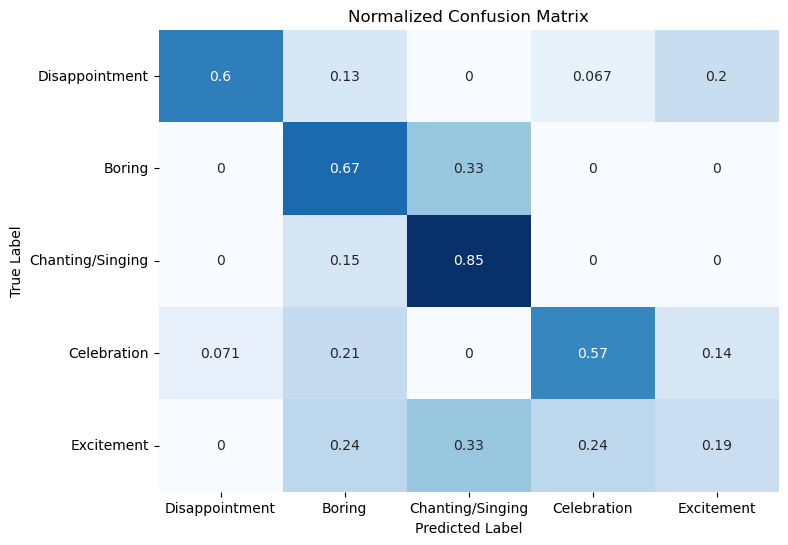

In [54]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", cbar=False, xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()